In [1]:
import yfinance as yahoo
import pandas as pd
import numpy as np
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt

# Stocks to work with, in relationship with Argentina CEDEARs

In [2]:
stocks = ['AAPL', 'ABEV', 'ABT', 'AGRO', 'AIG', 'AMD', 'AMZN', 'ARCO', 'AUY',
       'AXP', 'BA', 'BABA', 'BBD', 'BBVA', 'BCS', 'BIDU', 'BP', 'BRFS', 'C',
       'CRM', 'CSCO', 'CVX', 'DESP', 'DIS', 'EBAY', 'ERJ', 'FB', 'GE',
       'GGB', 'GILD', 'GLOB', 'GOLD', 'GOOGL', 'GS', 'GSK', 'HMY', 'HPQ',
       'IBM', 'INTC', 'ITUB', 'JNJ', 'JPM', 'KO', 'LYG', 'MCD', 'MELI', 'MMM',
       'MRK', 'MSFT', 'NFLX', 'NOK', 'NVDA', 'OGZPY', 'PBR', 'PFE', 'PG',
       'PYPL', 'QCOM','RTX', 'SLB', 'SNE', 'T', 'TEN','TGT', 'TOT', 'TRIP', 'TSLA',
       'TWTR', 'TX', 'UN', 'V', 'VALE', 'VIST', 'VOD', 'VZ', 'WFC', 'WMT',
       'X', 'XOM']

In [3]:
df = yahoo.download(stocks,period="1y",interval="60m")['Adj Close'].fillna(method='ffill')
df.pct_change().sum()

[*********************100%***********************]  79 of 79 completed


AAPL    0.793972
ABEV   -0.452178
ABT     0.378271
AGRO    0.040733
AIG    -0.362928
          ...   
VZ      0.025278
WFC    -0.524266
WMT     0.225726
X       0.064709
XOM    -0.548394
Length: 79, dtype: float64

# Optimize by Sharpe Ratio

In [4]:
noa = len(df.columns)
weigths = np.random.random(noa)
weigths /= np.sum(weigths)
observations = len(df.index)
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
alpha = 0.05
rf = 0.0


def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * observations
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(observations)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,0.15)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

optimal_port_sharpe = max_sharpe_ratio(mean_returns, cov, rf)

optimo = pd.DataFrame(index=df.columns)
optimo['weights'] = optimal_sharpe = pd.DataFrame([round(x,4) for x in optimal_port_sharpe['x']],index=df.columns)



# Optimize by minimizing the VaR

In [5]:
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, observations):
    portfolio_return = np.sum(mean_returns * weights) * observations
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(observations)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, observations):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, observations)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,0.15)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

min_port_VaR = min_VaR(mean_returns, cov, alpha, observations)

minimal_VaR = pd.DataFrame(index=df.columns)
minimal_VaR['weights'] = pd.DataFrame([round(x,4) for x in min_port_VaR['x']],index=df.columns)


# See minimal_VaR portofolio composition

In [6]:
minimal_VaR.sort_values('weights',axis=0,ascending=False)

,weights
TSLA,0.0766
NVDA,0.0662
AMD,0.0656
NFLX,0.0615
MELI,0.0433
...,...
BBD,0.0021
ABEV,0.0017
ERJ,0.0014
ITUB,0.0011


# See sharpe portofolio composition

In [7]:
optimo.sort_values('weights',axis=0,ascending=False)


,weights
RTX,0.1500
AMD,0.1500
TSLA,0.1500
NFLX,0.1276
NVDA,0.1196
...,...
GGB,0.0000
GE,0.0000
FB,0.0000
ERJ,0.0000


# Lets compare portfolios, assign weights and plit with benchmark of an 
# equally weighted portfolio from the stock selection

In [8]:
portfoliosharpe = (df * optimo.weights).T.sum()

portfoliominimal = (df * minimal_VaR.weights).T.sum()

benchmark = df.T.mean() # build an equally weigthed portfolio to use as benchmark

assets_return = df.pct_change().cumsum() # spectrum of the assets returns


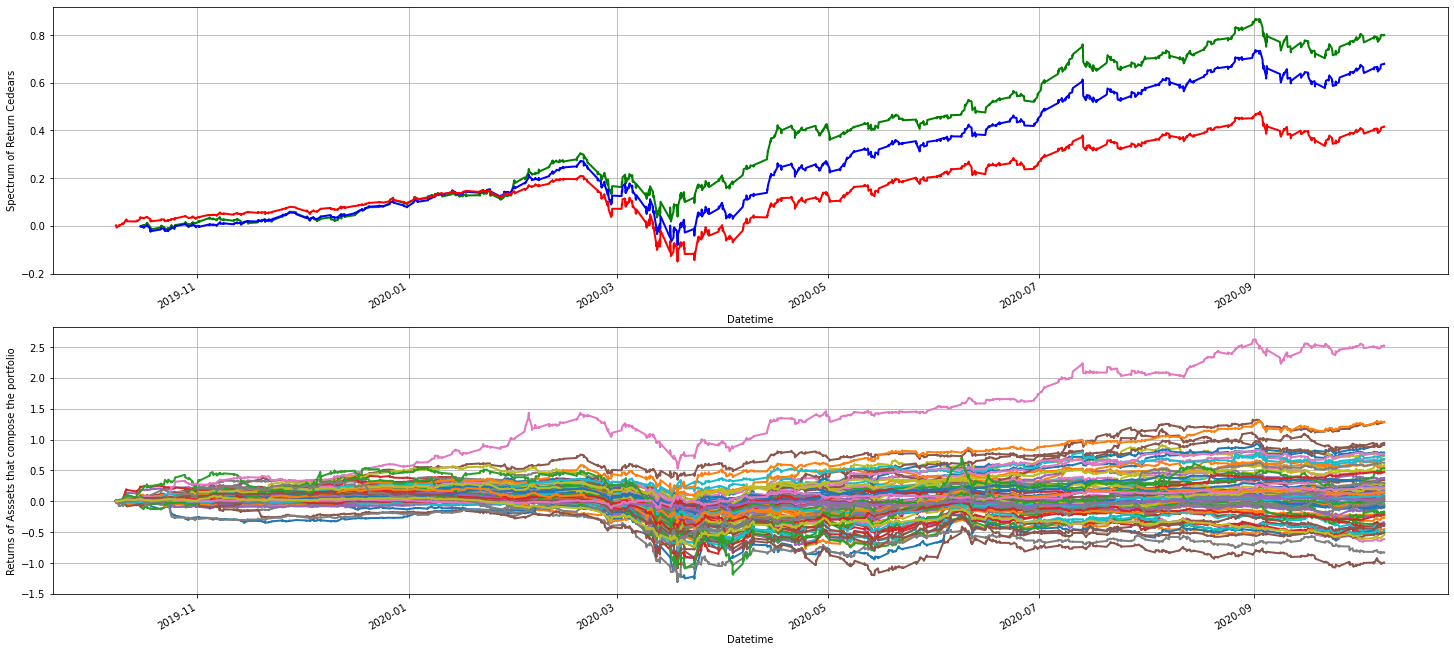

In [9]:
fig = plt.figure(figsize=(25,12))
ax1 = fig.add_subplot(211, ylabel='Spectrum of Return Cedears')
portfoliosharpe.tail(1767).pct_change(fill_method='bfill').cumsum().plot(ax=ax1, color='g', lw=2.)
portfoliominimal.tail(1767).pct_change(fill_method='bfill').cumsum().plot(ax=ax1, color='b', lw=2.)
benchmark.pct_change(fill_method='bfill').cumsum().plot(ax=ax1, color='r', lw=2.)
ax1.grid()
ax2 = fig.add_subplot(212, ylabel='Returns of Asssets that compose the portfolio')
assets_return.plot(ax=ax2, lw=2., legend=False)
ax2.grid()
plt.show()

In [10]:
portfoliosharpe, portfoliominimal, benchmark

(Datetime
 2019-10-08 11:30:00-04:00    284.236407
 2019-10-08 12:30:00-04:00    284.411061
 2019-10-08 13:30:00-04:00    284.061290
 2019-10-08 14:30:00-04:00    283.713053
 2019-10-08 15:30:00-04:00    281.721315
                                 ...    
 2020-10-08 11:31:12-04:00    620.960618
 2020-10-08 11:31:13-04:00    620.961848
 2020-10-08 11:31:14-04:00    620.961848
 2020-10-08 11:31:15-04:00    620.943898
 2020-10-08 11:31:16-04:00    620.943898
 Length: 1804, dtype: float64,
 Datetime
 2019-10-08 11:30:00-04:00    172.037268
 2019-10-08 12:30:00-04:00    172.350867
 2019-10-08 13:30:00-04:00    172.024919
 2019-10-08 14:30:00-04:00    171.841867
 2019-10-08 15:30:00-04:00    170.454392
                                 ...    
 2020-10-08 11:31:12-04:00    334.094146
 2020-10-08 11:31:13-04:00    334.093970
 2020-10-08 11:31:14-04:00    334.093959
 2020-10-08 11:31:15-04:00    334.084024
 2020-10-08 11:31:16-04:00    334.084157
 Length: 1804, dtype: float64,
 Datetime
 2019-

In [11]:
sharpe = pd.DataFrame(index=df.columns)
sharpe['weigths'] = pd.DataFrame([round(x,2) for x in optimal_port_sharpe['x']],index=df.columns)
sharpe.weigths.sort_values(axis=0,ascending=False)

TSLA     0.15
RTX      0.15
AMD      0.15
NFLX     0.13
NVDA     0.12
         ... 
NOK      0.00
OGZPY    0.00
PBR      0.00
PFE      0.00
AAPL     0.00
Name: weigths, Length: 79, dtype: float64

# Make a Risk Management Approach, the following is the CVaR Calculation

In [12]:
data = df

# Calculate the returns of instruments, statistics & correlation
returns = (data - data.shift(1))/ data.shift(1)# get the returns for every serie

statistics = returns.describe().T

statistics['mad'] = returns.mad()

statistics['skew'] = returns.skew()

statistics['kurtosis'] = returns.kurtosis()

statistics = statistics.T

correlation = returns.corr() # correlation

covariance = returns.cov()  # covariance

# Calculate the deltas of the instruments as the weights assigned multiplied by their correlations (elasticity)
instruments = pd.DataFrame(index= data.columns)
instruments['weigths'] = 1/len(instruments.index) # secure allocation is equal 1
instruments['deltas'] = (instruments.weigths * correlation).sum() # deltas as elasticity of the assets
instruments['Stdev'] = returns.std()
instruments['stress'] = (instruments.deltas * instruments.Stdev) * 3 # stress applied at 4 deviations
instruments['portfolio_stress'] = instruments.stress.sum() # the stress of the portfolio

# Optional, if all the worst events happen at once, must detect the worst deviation of the instruments and apply it simultaneously
poe = (returns / returns.std()).min()
fullstress = sum(instruments.stress.multiply(poe))


In [13]:
instruments

,weigths,deltas,Stdev,stress,portfolio_stress
AAPL,0.012658,0.517287,0.009434,0.014640,1.287569
ABEV,0.012658,0.418648,0.013632,0.017121,1.287569
ABT,0.012658,0.434737,0.008519,0.011111,1.287569
AGRO,0.012658,0.376680,0.015009,0.016961,1.287569
AIG,0.012658,0.499717,0.015526,0.023276,1.287569
...,...,...,...,...,...
VZ,0.012658,0.426915,0.005986,0.007667,1.287569
WFC,0.012658,0.512015,0.012175,0.018701,1.287569
WMT,0.012658,0.291401,0.006886,0.006020,1.287569
X,0.012658,0.391347,0.018816,0.022091,1.287569


In [14]:
poe, fullstress

(AAPL   -10.937056
 ABEV    -8.411335
 ABT    -10.316227
 AGRO   -12.074401
 AIG    -10.791983
           ...    
 VZ      -8.944820
 WFC     -9.703800
 WMT     -7.855403
 X       -8.143253
 XOM     -7.486217
 Length: 79, dtype: float64,
 -13.885557619387267)

In [15]:
portfolio = data.T.mean()
portfolio

Datetime
2019-10-08 11:30:00-04:00    110.198030
2019-10-08 12:30:00-04:00    110.436488
2019-10-08 13:30:00-04:00    110.300936
2019-10-08 14:30:00-04:00    110.228554
2019-10-08 15:30:00-04:00    109.437925
                                ...    
2020-10-08 11:31:12-04:00    159.238178
2020-10-08 11:31:13-04:00    159.237653
2020-10-08 11:31:14-04:00    159.237640
2020-10-08 11:31:15-04:00    159.235740
2020-10-08 11:31:16-04:00    159.235867
Length: 1804, dtype: float64

In [16]:
portfolio_returns = (portfolio - portfolio.shift(1))/ portfolio.shift(1)

portfolio_stats = portfolio_returns.describe(percentiles=[.01,.05,.10]).T

portfolio_stats['var'] = portfolio_returns.var()

portfolio_stats['skew'] = portfolio_returns.skew()

portfolio_stats['Kurtosis'] = portfolio_returns.kurtosis()

In [17]:
risk = pd.DataFrame(index=data.columns)
risk['numerator'] = (instruments.deltas.multiply(covariance)).sum()
risk['denominator'] = portfolio_returns.std() * (-2.32635) # at 1% of inverse normal dist.
risk['GradVaR'] = -risk.numerator / risk.denominator
risk['CVaRj'] = risk.GradVaR * instruments.deltas # Component VaR of the Risk Factors j
risk['thetai'] = (risk.CVaRj * correlation).sum() # Theta i of the instruments
risk['CVaRi'] = risk.thetai * (1/len(data.columns)) # Component VaR of the Instruments i
risk['totalCVaRi'] = risk.CVaRi.sum() #total CVaR of the portfolio
risk['CVaRattribution'] = risk.CVaRi / risk.totalCVaRi # risk allocation by instrument in the portfolio
risk

,numerator,denominator,GradVaR,CVaRj,thetai,CVaRi,totalCVaRi,CVaRattribution
AAPL,0.002368,-0.017147,0.138122,0.071449,2.919798,0.036959,2.454195,0.015060
ABEV,0.002377,-0.017147,0.138621,0.058034,1.919354,0.024296,2.454195,0.009900
ABT,0.001457,-0.017147,0.084961,0.036936,1.268521,0.016057,2.454195,0.006543
AGRO,0.002131,-0.017147,0.124308,0.046824,1.393390,0.017638,2.454195,0.007187
AIG,0.003856,-0.017147,0.224875,0.112374,4.436256,0.056155,2.454195,0.022881
...,...,...,...,...,...,...,...,...
VZ,0.000989,-0.017147,0.057677,0.024623,0.830444,0.010512,2.454195,0.004283
WFC,0.003118,-0.017147,0.181840,0.093105,3.766010,0.047671,2.454195,0.019424
WMT,0.000504,-0.017147,0.029381,0.008562,0.197096,0.002495,2.454195,0.001017
X,0.002879,-0.017147,0.167895,0.065705,2.031366,0.025713,2.454195,0.010477


In [18]:
cartera = pd.DataFrame(index=data.columns)
cartera['base'] = instruments.weigths
cartera['CVaRattribution'] = risk.CVaRattribution.sort_values(axis=0,ascending=False)
cartera['new'] = minimal_VaR.weights
cartera['condition'] = (cartera.base  * cartera.CVaRattribution)
cartera['newrisk'] = (cartera.new  * cartera.CVaRattribution)
cartera['differences'] = (cartera.newrisk - cartera.condition)  # apply this result as a percentage to multiply new weights
cartera['adjustments'] = (cartera.newrisk - cartera.condition) / cartera.condition #ALARM if its negative sum up the difference, 
                                            #if it is positive rest it, you need to have 0
cartera['suggested'] = cartera.new * (1 + cartera.adjustments)   
cartera['tototal'] = cartera.suggested.sum()
cartera['MinCVaR'] = cartera.suggested / cartera.tototal
cartera

,base,CVaRattribution,new,condition,newrisk,differences,adjustments,suggested,tototal,MinCVaR
AAPL,0.012658,0.015060,0.0177,0.000191,0.000267,0.000076,0.3983,0.024750,2.272433,0.010891
ABEV,0.012658,0.009900,0.0017,0.000125,0.000017,-0.000108,-0.8657,0.000228,2.272433,0.000100
ABT,0.012658,0.006543,0.0099,0.000083,0.000065,-0.000018,-0.2179,0.007743,2.272433,0.003407
AGRO,0.012658,0.007187,0.0050,0.000091,0.000036,-0.000055,-0.6050,0.001975,2.272433,0.000869
AIG,0.012658,0.022881,0.0106,0.000290,0.000243,-0.000047,-0.1626,0.008876,2.272433,0.003906
...,...,...,...,...,...,...,...,...,...,...
VZ,0.012658,0.004283,0.0052,0.000054,0.000022,-0.000032,-0.5892,0.002136,2.272433,0.000940
WFC,0.012658,0.019424,0.0074,0.000246,0.000144,-0.000102,-0.4154,0.004326,2.272433,0.001904
WMT,0.012658,0.001017,0.0074,0.000013,0.000008,-0.000005,-0.4154,0.004326,2.272433,0.001904
X,0.012658,0.010477,0.0133,0.000133,0.000139,0.000007,0.0507,0.013974,2.272433,0.006149


# Cartera['MinCVaR'] are the weights for the CVaR Portfolio

In [19]:
propuesta = data * cartera.MinCVaR
propuesta = propuesta.T.sum()

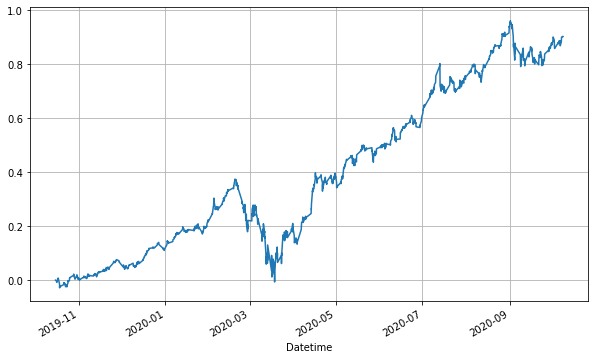

In [20]:
p = propuesta.tail(1767).pct_change().cumsum().plot(figsize=(10,6))
p.grid()

In [21]:
propuesta

Datetime
2019-10-08 11:30:00-04:00    199.260713
2019-10-08 12:30:00-04:00    199.600922
2019-10-08 13:30:00-04:00    199.133503
2019-10-08 14:30:00-04:00    198.825055
2019-10-08 15:30:00-04:00    197.132083
                                ...    
2020-10-08 11:31:12-04:00    479.645917
2020-10-08 11:31:13-04:00    479.645920
2020-10-08 11:31:14-04:00    479.645917
2020-10-08 11:31:15-04:00    479.623051
2020-10-08 11:31:16-04:00    479.623112
Length: 1804, dtype: float64

In [22]:
ponderaciones = pd.DataFrame(index=cartera.index)
ponderaciones['weights'] = cartera.MinCVaR.sort_values(axis=0)
alocacion = pd.DataFrame(index=optimo.index)

ponderaciones.head(15)

,weights
AAPL,0.010891
ABEV,0.000100
ABT,0.003407
AGRO,0.000869
AIG,0.003906
AMD,0.149604
AMZN,0.037629
ARCO,0.003760
AUY,0.017133
AXP,0.002225


In [23]:
d = df.tail(1).T

da = pd.DataFrame(index=d.index)

da['precios'] = d

In [24]:
portfoliocvar = propuesta

In [25]:
carteras = pd.DataFrame(index=df.index)
carteras['sharpe'] = portfoliosharpe
carteras['minvar'] = portfoliominimal
carteras['cvar'] = portfoliocvar
carteras['benchmark'] = benchmark
carteras

,sharpe,minvar,cvar,benchmark
Datetime,,,,
2019-10-08 11:30:00-04:00,284.236407,172.037268,199.260713,110.198030
2019-10-08 12:30:00-04:00,284.411061,172.350867,199.600922,110.436488
2019-10-08 13:30:00-04:00,284.061290,172.024919,199.133503,110.300936
2019-10-08 14:30:00-04:00,283.713053,171.841867,198.825055,110.228554
2019-10-08 15:30:00-04:00,281.721315,170.454392,197.132083,109.437925
...,...,...,...,...
2020-10-08 11:31:12-04:00,620.960618,334.094146,479.645917,159.238178
2020-10-08 11:31:13-04:00,620.961848,334.093970,479.645920,159.237653
2020-10-08 11:31:14-04:00,620.961848,334.093959,479.645917,159.237640


# Plot different choices

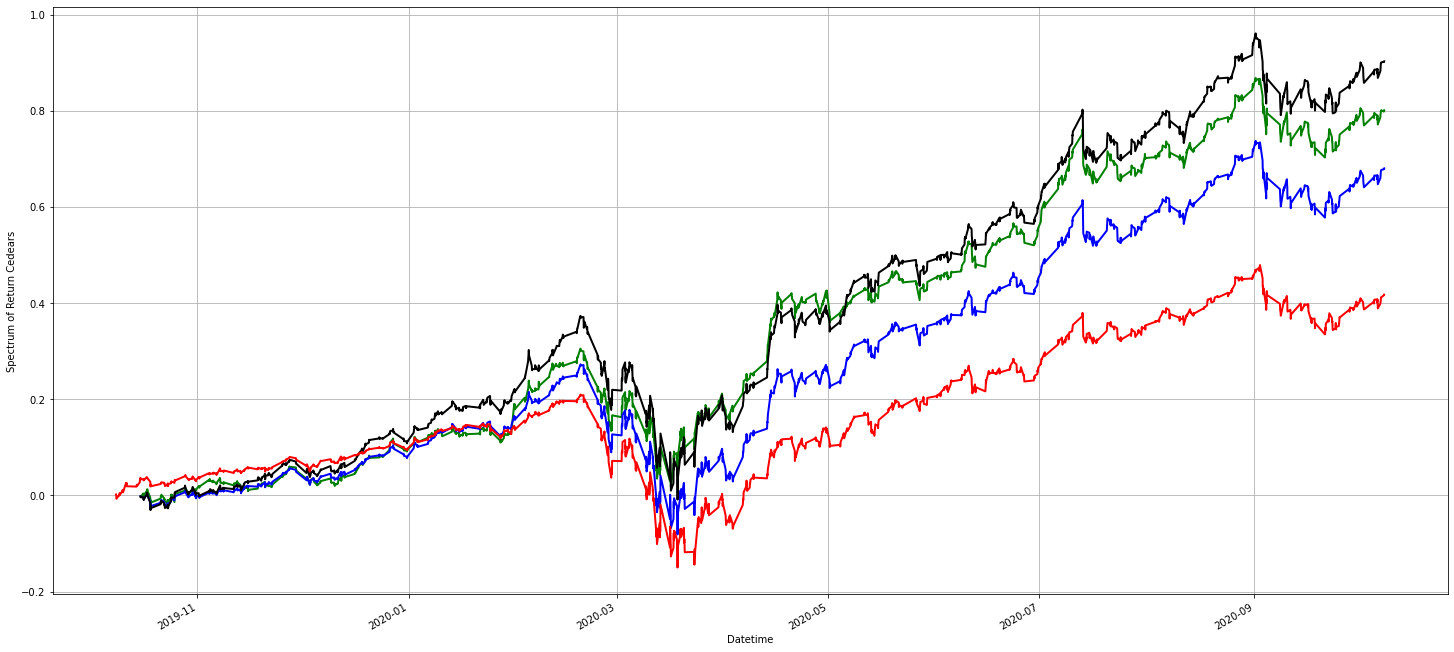

In [26]:
fig = plt.figure(figsize=(25,12))
ax1 = fig.add_subplot(111, ylabel='Spectrum of Return Cedears')
portfoliosharpe.tail(1767).pct_change(fill_method='bfill').cumsum().plot(ax=ax1, color='g', lw=2.)
portfoliominimal.tail(1767).pct_change(fill_method='bfill').cumsum().plot(ax=ax1, color='b', lw=2.)
portfoliocvar.tail(1767).pct_change(fill_method='bfill').cumsum().plot(ax=ax1, color='k', lw=2.)
benchmark.pct_change(fill_method='bfill').cumsum().plot(ax=ax1, color='r', lw=2.)
ax1.grid()


# Now get the tickets with their respective changes via yahoo
# get the last price and see how to apply weights given the initial capital

In [27]:
BA = ['AAPL.BA', 'ABEV.BA', 'ABT.BA', 'ADGO.BA', 'AIG.BA', 'AMD.BA',
       'AMZN.BA', 'ARCO.BA', 'AUY.BA', 'AXP.BA', 'BA.BA', 'BABA.BA', 'BBD.BA',
       'BBV.BA', 'BCS.BA', 'BIDU.BA', 'BP.BA', 'BRFS.BA', 'C.BA', 'CRM.BA',
       'CSCO.BA', 'CVX.BA', 'DESP.BA', 'DISN.BA', 'EBAY.BA', 'ERJ.BA',
       'FB.BA', 'GE.BA', 'GGB.BA', 'GILD.BA', 'GLNT.BA', 'GOLD.BA', 'GOOGL.BA',
       'GS.BA', 'GSK.BA', 'HMY.BA', 'HPQ.BA', 'IBM.BA', 'INTC.BA', 'ITUB.BA',
       'JNJ.BA', 'JPM.BA', 'KO.BA', 'LYG.BA', 'MCD.BA', 'MELI.BA', 'MMM.BA',
       'MRK.BA', 'MSFT.BA', 'NFLX.BA', 'NOKA.BA', 'NVDA.BA', 'OGZD.BA',
       'PBR.BA', 'PFE.BA', 'PG.BA', 'PYPL.BA', 'QCOM.BA','RTX.BA', 'SLB.BA',
       'SNE.BA', 'T.BA', 'TEN.BA','TGT.BA', 'TOT.BA', 'TRIP.BA', 'TSLA.BA', 'TWTR.BA',
       'TXR.BA', 'UN.BA', 'V.BA', 'VALE.BA', 'VIST.BA', 'VOD.BA', 'VZ.BA',
       'WFC.BA', 'WMT.BA', 'X.BA', 'XOM.BA']
cedears = yahoo.download(BA,period="5d",interval="2m")['Adj Close'].fillna(method='ffill')
ultimo = pd.DataFrame(index=cedears.columns)
ultimo['precio'] = cedears.tail(1).T.values

[*********************100%***********************]  79 of 79 completed


# Minival_VaR Portfolio

In [28]:
# Cartera por Mínimo VaR
minvarport = pd.DataFrame(index=cedears.columns)
minvarport['capital'] = float(1000000) # thousands
minvarport['precio'] = cedears.tail(1).T.values
minvarport['weights'] = (minimal_VaR['weights'].values).round(2)
minvarport['efectivo'] = (minvarport['capital'] * minvarport['weights'])
minvarport['fracción'] =  minvarport['efectivo'] / minvarport['precio'] 
minvarport['redondo'] = minvarport['fracción'].round()
minvarport['invertido'] = minvarport['precio'] * minvarport['redondo']
minvarport['porcentage'] = minvarport['invertido'] / sum(minvarport['invertido'])
minvarport['total'] = sum(minvarport['invertido'])
minvarport

,capital,precio,weights,efectivo,fracción,redondo,invertido,porcentage,total
AAPL.BA,1000000.0,1755.5,0.02,20000.0,11.392766,11.0,19310.5,0.019631,983664.0
ABEV.BA,1000000.0,1116.0,0.00,0.0,0.000000,0.0,0.0,0.000000,983664.0
ABT.BA,1000000.0,8213.0,0.01,10000.0,1.217582,1.0,8213.0,0.008349,983664.0
ADGO.BA,1000000.0,1514.0,0.00,0.0,0.000000,0.0,0.0,0.000000,983664.0
AIG.BA,1000000.0,910.0,0.01,10000.0,10.989011,11.0,10010.0,0.010176,983664.0
...,...,...,...,...,...,...,...,...,...
VZ.BA,1000000.0,4500.0,0.01,10000.0,2.222222,2.0,9000.0,0.009149,983664.0
WFC.BA,1000000.0,758.0,0.01,10000.0,13.192612,13.0,9854.0,0.010018,983664.0
WMT.BA,1000000.0,7200.0,0.01,10000.0,1.388889,1.0,7200.0,0.007320,983664.0
X.BA,1000000.0,428.0,0.01,10000.0,23.364486,23.0,9844.0,0.010007,983664.0


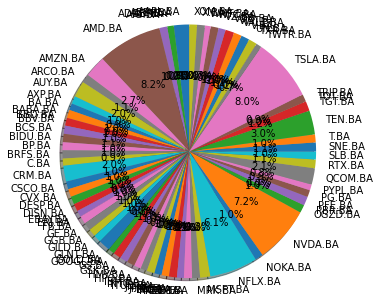

In [29]:
labels = list(minvarport.index)
sizes = minvarport.porcentage.values

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, labels=labels,autopct='%1.1f%%',
       shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

# Sharpe Portfolio

In [30]:
# Cartera Max Sharpe
sharport = pd.DataFrame(index=cedears.columns)
sharport['capital'] = float(1000000) # thousands
sharport['precio'] = cedears.tail(1).T.values
sharport['weights'] = (optimo.weights.values).round(2)
sharport['efectivo'] = (sharport['capital'] * sharport['weights'])
sharport['fracción'] =  sharport['efectivo'] / sharport['precio'] 
sharport['redondo'] = sharport['fracción'].round()
sharport['invertido'] = sharport['precio'] * sharport['redondo']
sharport['porcentage'] = sharport['invertido'] / sum(sharport['invertido'])
sharport['total'] = sum(sharport['invertido'])
sharport

,capital,precio,weights,efectivo,fracción,redondo,invertido,porcentage,total
AAPL.BA,1000000.0,1755.5,0.0,0.0,0.0,0.0,0.0,0.0,1011800.5
ABEV.BA,1000000.0,1116.0,0.0,0.0,0.0,0.0,0.0,0.0,1011800.5
ABT.BA,1000000.0,8213.0,0.0,0.0,0.0,0.0,0.0,0.0,1011800.5
ADGO.BA,1000000.0,1514.0,0.0,0.0,0.0,0.0,0.0,0.0,1011800.5
AIG.BA,1000000.0,910.0,0.0,0.0,0.0,0.0,0.0,0.0,1011800.5
...,...,...,...,...,...,...,...,...,...
VZ.BA,1000000.0,4500.0,0.0,0.0,0.0,0.0,0.0,0.0,1011800.5
WFC.BA,1000000.0,758.0,0.0,0.0,0.0,0.0,0.0,0.0,1011800.5
WMT.BA,1000000.0,7200.0,0.0,0.0,0.0,0.0,0.0,0.0,1011800.5
X.BA,1000000.0,428.0,0.0,0.0,0.0,0.0,0.0,0.0,1011800.5


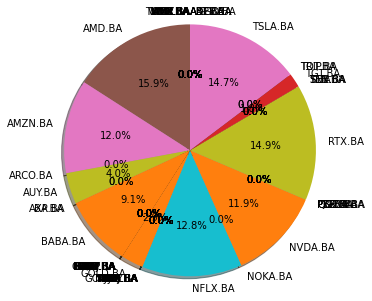

In [31]:
labels = list(sharport.index)
sizes = sharport.porcentage.values

fig2, ax2 = plt.subplots(figsize=(5,5))
ax2.pie(sizes, labels=labels,autopct='%1.1f%%',
       shadow=True, startangle=90)
ax2.axis('equal')

plt.show()

# CVaR Portfolio

In [32]:
# Cartera CVaR Portfolio
cvarport = pd.DataFrame(index=cedears.columns)
cvarport['capital'] = float(1000000) # thousands
cvarport['precio'] = cedears.tail(1).T.values
cvarport['weights'] = (cartera.MinCVaR.values).round(2)
cvarport['efectivo'] = (cvarport['capital'] * cvarport['weights'])
cvarport['fracción'] =  cvarport['efectivo'] / cvarport['precio'] 
cvarport['redondo'] = cvarport['fracción'].round()
cvarport['invertido'] = cvarport['precio'] * cvarport['redondo']
cvarport['porcentage'] = cvarport['invertido'] / sum(cvarport['invertido'])
cvarport['total'] = sum(cvarport['invertido'])
cvarport

,capital,precio,weights,efectivo,fracción,redondo,invertido,porcentage,total
AAPL.BA,1000000.0,1755.5,0.01,10000.0,5.696383,6.0,10533.0,0.010891,967157.0
ABEV.BA,1000000.0,1116.0,0.00,0.0,0.000000,0.0,0.0,0.000000,967157.0
ABT.BA,1000000.0,8213.0,0.00,0.0,0.000000,0.0,0.0,0.000000,967157.0
ADGO.BA,1000000.0,1514.0,0.00,0.0,0.000000,0.0,0.0,0.000000,967157.0
AIG.BA,1000000.0,910.0,0.00,0.0,0.000000,0.0,0.0,0.000000,967157.0
...,...,...,...,...,...,...,...,...,...
VZ.BA,1000000.0,4500.0,0.00,0.0,0.000000,0.0,0.0,0.000000,967157.0
WFC.BA,1000000.0,758.0,0.00,0.0,0.000000,0.0,0.0,0.000000,967157.0
WMT.BA,1000000.0,7200.0,0.00,0.0,0.000000,0.0,0.0,0.000000,967157.0
X.BA,1000000.0,428.0,0.01,10000.0,23.364486,23.0,9844.0,0.010178,967157.0


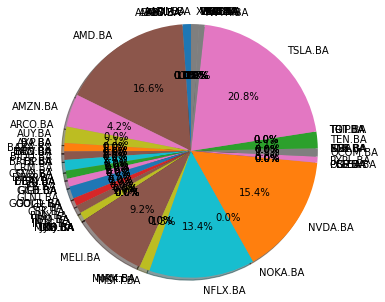

In [33]:
labels = list(cvarport.index)
sizes = cvarport.porcentage.values

fig3, ax3 = plt.subplots(figsize=(5,5))
ax3.pie(sizes, labels=labels,autopct='%1.1f%%',
       shadow=True, startangle=90)
ax3.axis('equal')

plt.show()

In [34]:
writer = pd.ExcelWriter('portfoliosApproach.xlsx', engine='xlsxwriter')

In [35]:
minvarport.to_excel(writer, sheet_name='cartera minVaR')

sharport.to_excel(writer, sheet_name='cartera sharpe')

cvarport.to_excel(writer, sheet_name='cartera riesgo CVaR')

carteras.to_excel(writer, sheet_name='evolución cada cartera', index=False)

df.to_excel(writer, sheet_name='series tiempo activos', index=False)

returns.to_excel(writer, sheet_name='retorno activos', index=False)

statistics.to_excel(writer, sheet_name='estadisticos')

correlation.to_excel(writer, sheet_name='correlaciones')

covariance.to_excel(writer, sheet_name='covarianza')

instruments.to_excel(writer, sheet_name='datos riesgo instrumentos')

risk.to_excel(writer, sheet_name='medidas de riesgo')

cartera.to_excel(writer, sheet_name='optimizo por mincvar')

In [36]:
writer.save()